In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Introduction
In this Notebook we show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost
 
In the pre-processing steps, we convert the non numerical features using the LabelEncoding for most of the columns, i.e.for
the columns that have only two possible values or more than two sortable values. The only column that has not these characteristic is the MTRANS, where we apply the one-hot encoding.

Then we do some data exploration, analyzing the correlation between numerical features and labels, the distribution of train and test data, the distribution of labels, etc...

Then we train 4 different baseline classifier: RandomForest, GradientBoosting, LightGBM and XGBoost, XGBoost shows the best performance, so we decide to optimize
its hyperparameters by using the framework Optuna.

Finally we perfrom the predictions in two ways:

 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5


## 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [4]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col = 0)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In particular we can deduct that:

- 'Gender', 'Age', 'Height', 'Weight' are physical attributes
- 'family_history_with_overweight' points out to familiarity with obesity
- FAVC = Frequent consumption of high caloric food
- FCVC = Frequency of consumption of vegetables
- NCP = Number of main meals
- CAEC = Consumption of food between meals
- SMOKE = tobacco usage
- CH20 = Consumption of water daily
- SCC = Calories consumption monitoring
- FAF = Physical activity frequency
- TUE = Time using technology devices
- CALC = Consumption of alcohol
- MTRANS = Transportation used

In [5]:
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

## 2.Data exploration and pre-processing

### Numerical DataFrame

In [6]:
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
id,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721
...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439


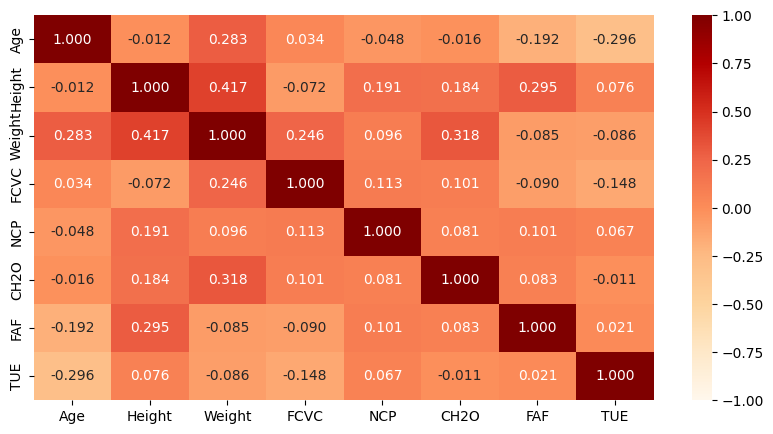

In [7]:
corr_numerical = df_numerical.corr()

import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(corr_numerical, annot=True, cmap="OrRd", fmt='.3f', cbar=True, vmin=-1, vmax=1)
plt.show()

### Categorical DataFrame

In [8]:
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


Gender
Female    10422
Male      10336
Name: count, dtype: int64
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
FAVC
yes    18982
no      1776
Name: count, dtype: int64
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SCC
no     20071
yes      687
Name: count, dtype: int64
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


## Encoding

In [9]:
df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
# One-Hot encoding
df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
df_encoded.drop('MTRANS', axis=1, inplace=True)

# concatenate
# one feature of df_encoded is redundant; we can remove it
df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, 0:-1]], axis = 1)

df_encoded

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation
id,,,,,,,,,,,
0,0,1,1,1,0,0,1,0,0,0,1
1,1,1,1,2,0,0,0,1,0,0,0
2,1,1,1,1,0,0,0,0,0,0,1
3,1,1,1,1,0,0,1,0,0,0,1
4,0,1,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
20753,0,1,1,1,0,0,1,0,0,0,1
20754,0,0,1,2,0,0,1,0,0,0,1
20755,0,1,1,1,0,0,0,0,0,0,1


### Concatenate all features together

In [10]:
df_all_features = pd.concat([df_numerical, df_encoded], axis = 1)

df_all_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation
id,,,,,,,,,,,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,0,1,1,1,0,0,1,0,0,0,1
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1,1,1,2,0,0,0,1,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,1,1,1,1,0,0,0,0,0,0,1
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,1,1,1,1,0,0,1,0,0,0,1
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,0,1,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,0,1,1,1,0,0,1,0,0,0,1
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,0,0,1,2,0,0,1,0,0,0,1
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,0,1,1,1,0,0,0,0,0,0,1


### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [11]:
def apply_preprocessing(data):
    features = data.copy(deep=True)
    
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
    
    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    # one-hot encoding
    df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
    df_encoded.drop('MTRANS', axis=1, inplace=True)

    # concatenate
    # one feature of df_encoded is redundant; we can remove it
    df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, 0:-1]], axis=1)
    
    df_all_features = pd.concat([df_numerical, df_encoded], axis=1)
    
    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [12]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col =0)

df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)

assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation'],
      dtype='object')


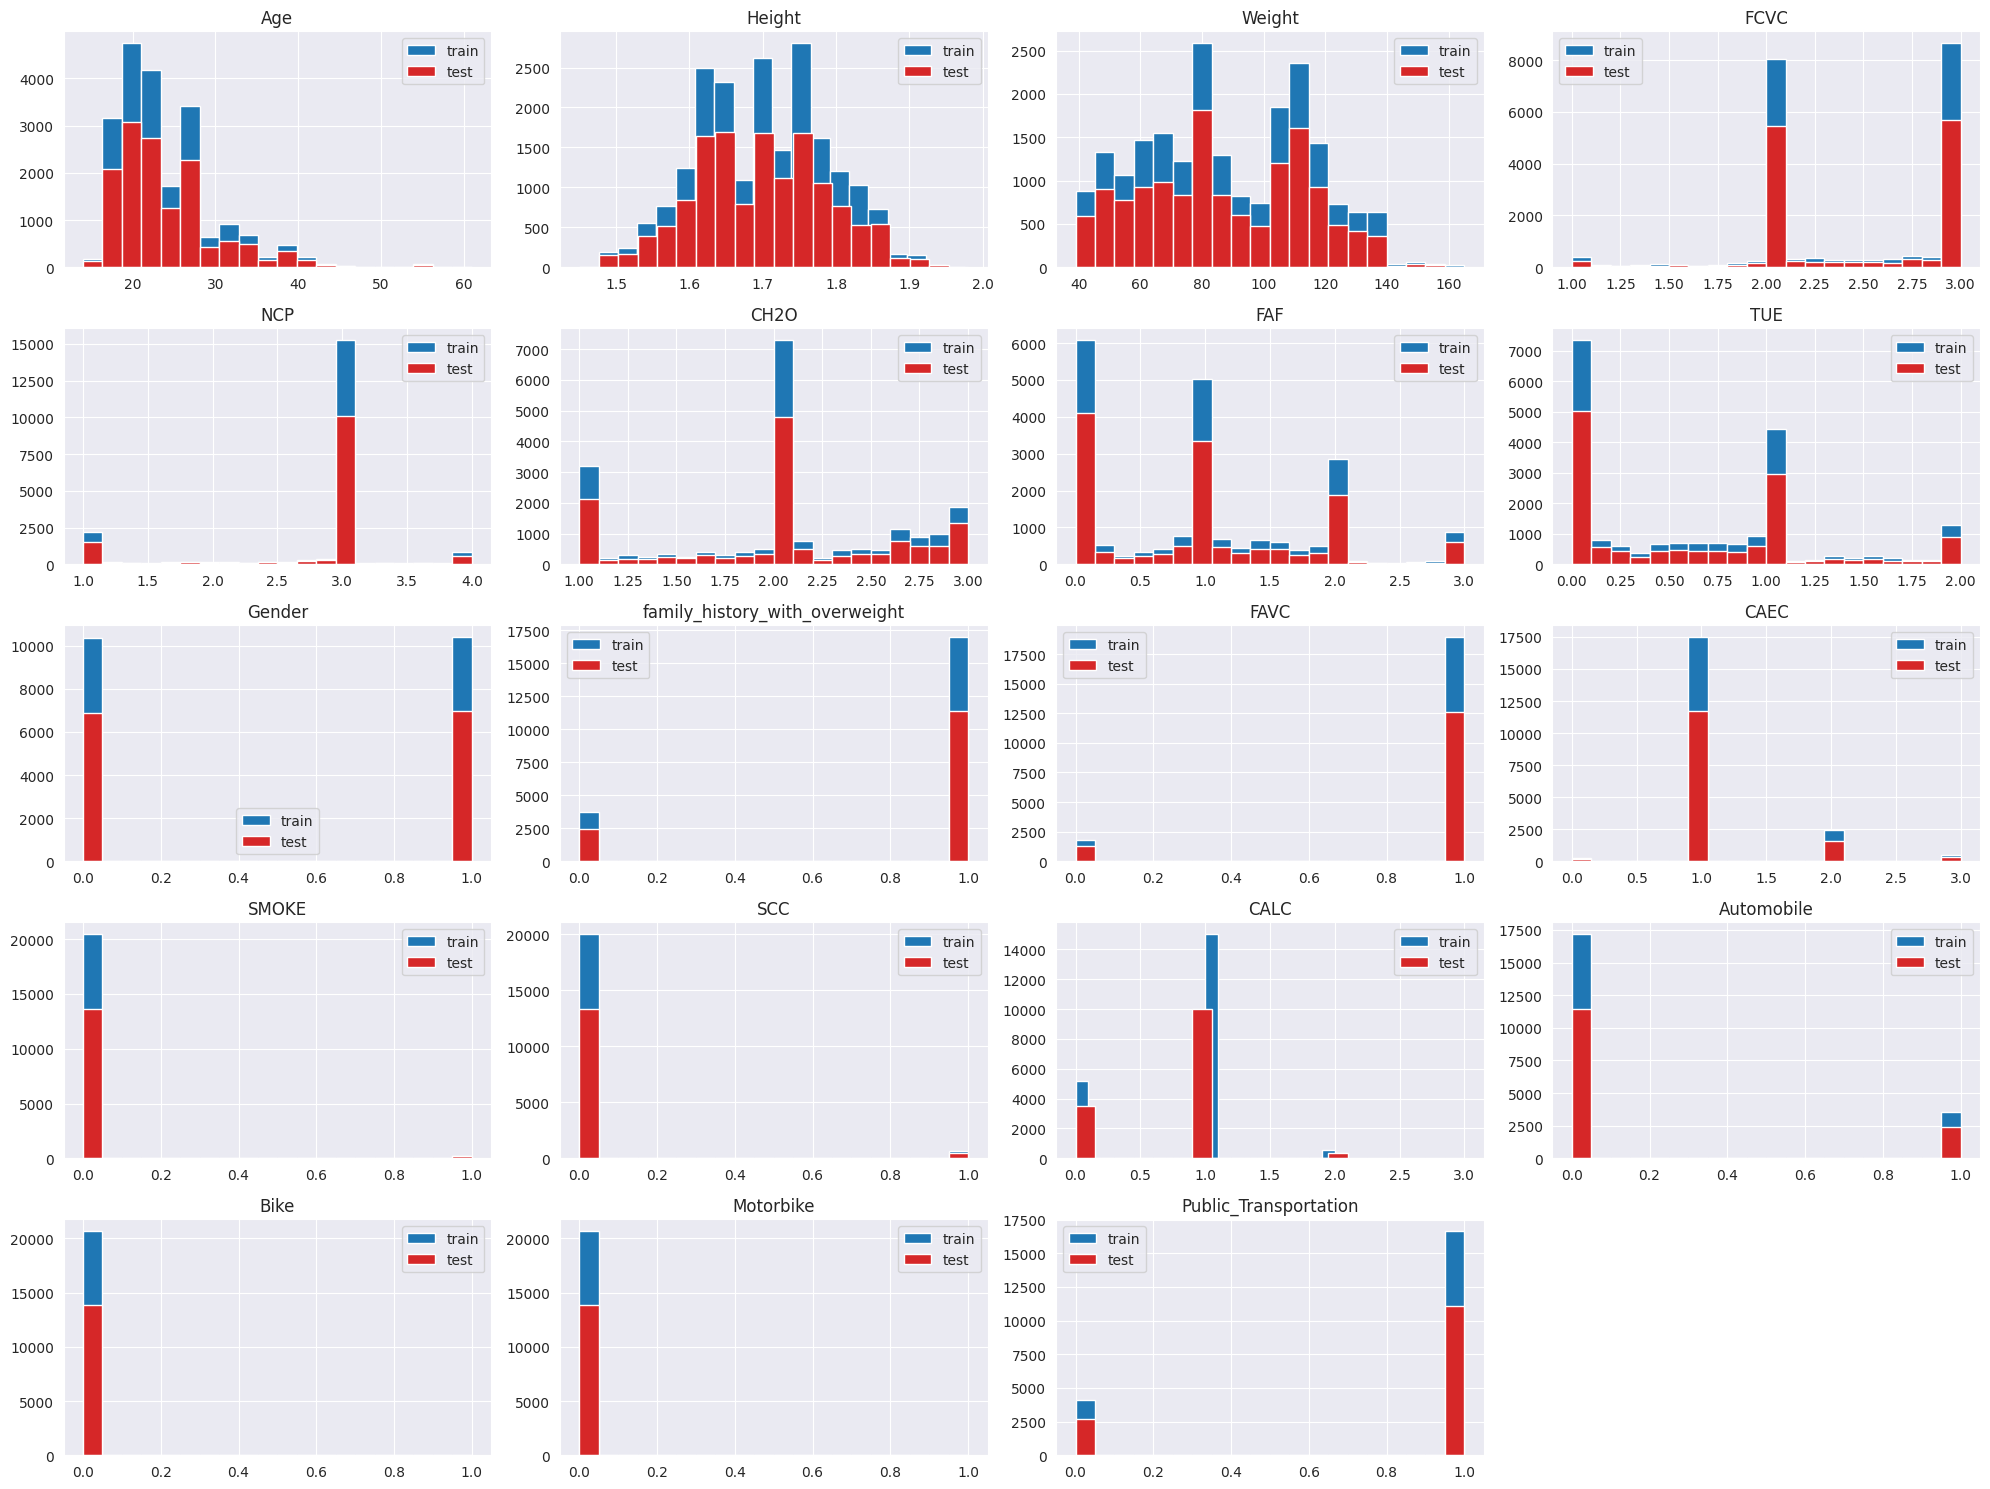

In [13]:
sns.set_style('dark')

plt.figure(figsize=(20, 15))

for i in range(df_all_features.shape[1]):
    plt.subplot(5, 4, i+1)
    plt.hist(df_all_features.iloc[:, i], bins=20, label='train')
    plt.hist(df_test.iloc[:, i], bins=20,
             alpha=1, label='test', color='C3')
    plt.title(df_all_features.columns[i])
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

### Labels

In [14]:
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [15]:
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded


,NObeyesdad
id,
0,3
1,1
2,0
3,6
4,3
...,...
20753,5
20754,0
20755,5


In [16]:
labels_encoded.value_counts()

NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
Name: count, dtype: int64

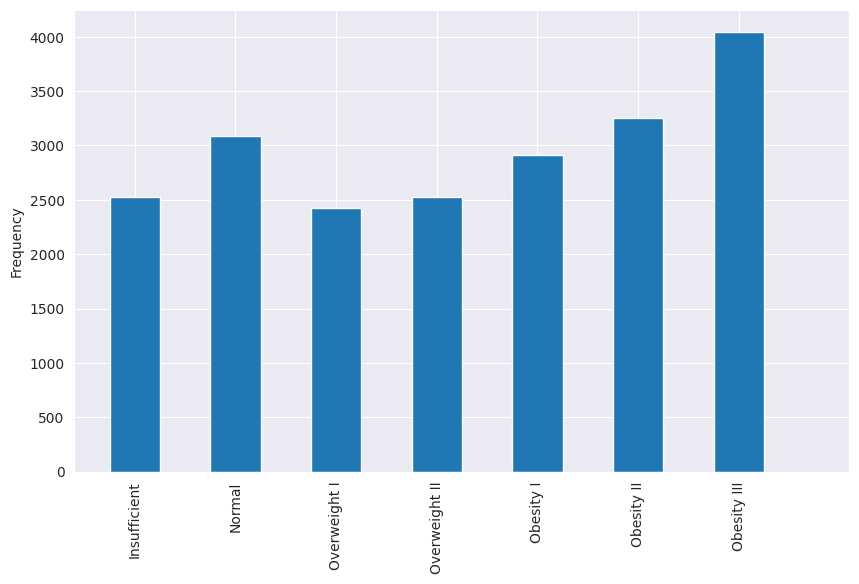

In [17]:
sns.set_style('dark')

plt.figure(figsize=(10,6))
plt.hist(labels_encoded, bins=np.arange(0, 8)-0.25, width=0.5, align='mid')
plt.grid()
plt.xticks(np.arange(0, 6.1),
          ['Insufficient', 'Normal', 'Overweight I', 'Overweight II', 'Obesity I', 'Obesity II', 'Obesity III'],
          rotation= 90)

plt.ylabel('Frequency')
plt.show()

## 3.Prepare data for machine learning

In [18]:
X = df_all_features
y = np.ravel(labels_encoded)

# compare train and test data
X_test = df_test
assert all(X_test.columns == X.columns), "Columns of trainging and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Number of samples 20758
Number of featires 19


## Fit the data with baseline models

In [19]:
'''
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights based on the training data
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y),
                                     y=y)

class_weights = dict(zip(np.unique(y), class_weights))
class_weights
'''

"\nfrom sklearn.utils.class_weight import compute_class_weight\n\n# calculate class weights based on the training data\nclass_weights = compute_class_weight('balanced', \n                                     classes=np.unique(y),\n                                     y=y)\n\nclass_weights = dict(zip(np.unique(y), class_weights))\nclass_weights\n"

In [20]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)
    
    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
    
    print('=========================================')

In [22]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 1.0
Test score 0.895
Overfitting detected
LightGBM
Train score 0.979
Test score 0.905
Overfitting detected
Gradient Boosting
Train score 0.923
Test score 0.903
XGBoost
Train score 0.987
Test score 0.905
Overfitting detected


## 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier defined in the previous section, using the optimizer framework called Optuna

In [23]:
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost
    params = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'gamma': gamma,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'eval_metric':'mlogloss'}
        
    clf = XGBClassifier(**params)
    
    '''
    # LightGBM
    params = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'lambda_l1': reg_alpha,
              'lambda_l2': reg_lambda,
              'colsample_bytree': colsample_bytree, 
              'subsample': subsample,    
              'min_child_samples': min_child_weight,
              'class_weight': 'balanced'}
    
    clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)
    '''
    
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [ ]:
# Uncomment this section if you want to do hyperparameter tuning

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-02-24 14:28:36,087] A new study created in memory with name: no-name-e6b997ba-eae8-4e2a-8940-2c53ea41b7c4


Training the model with 19 features


In [ ]:
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study.head()

In [ ]:
#best_params_XGB = study.best_params

# Best parameters for XGBoost obtained after Optuna optimization
best_params_XGB = {'max_depth': 10, 
                   'n_estimators': 1224, 
                   'gamma': 0.8323134488556143, 
                   'reg_alpha': 0.9211957174104992, 
                   'reg_lambda': 0.8522905506401445, 
                   'min_child_weight': 4, 
                   'subsample': 0.9232723357974977, 
                   'colsample_bytree': 0.4785000546841373, 
                   'learning_rate': 0.06435693511798936}

print(best_params_XGB)

Also hyperparameters for LightGBM Classifier have been optimized. In case you want to test it, please un comment the following cell.

In [ ]:
# Best parameters for LightGBM obtained after Optuna optimization
best_params_LGBM = {'max_depth': 5, 
                    'n_estimators': 1086, 
                    'gamma': 0.21718199012686834, 
                    'lambda_l1': 0.9770735787707583, 
                    'lambda_l2': 0.8576215710818857, 
                    'min_child_samples': 4, 
                    'subsample': 0.9343204270146038, 
                    'colsample_bytree': 0.6782348565590313, 
                    'learning_rate': 0.014669435683414833}

print(best_params_LGBM)

## 6. Train the best model and export the results

In [ ]:
# train the best model
clf = XGBClassifier(**best_params_XGB)
# clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)

clf.fit(X, y)

predictions = clf.predict(X_test)

In [ ]:
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.to_csv('submission.csv', index=False)

In [ ]:
df_features = pd.DataFrame(clf.feature_importances_, index = X.columns, columns = ['Feature importances'])
df_features = df_features.sort_values('Feature importances')

df_features.plot(kind='barh')
plt.grid()
plt.xlabel('Feature importance')
plt.show()

## 7. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, X_test):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(X)[train_index, :]
        y_train = np.array(y)[train_index]
        X_val = np.array(X)[val_index, :]
        y_val = np.array(y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        clf = XGBClassifier(**best_params_XGB)
        clf.fit(X=X_train, y=y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=10,
                verbose=50)
        
        #clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
        #clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
        
        y_pred_val = clf.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test_proba = clf.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(clf)
        
    return scores, np.array(predictions), clfs

In [ ]:
scores, predictions, clfs = train_evaluate_model(X, y, X_test)

In [ ]:
print('Average evaluation score = ', np.mean(scores))

In [ ]:
y_test_pred = np.mean(predictions. axis= 0)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_pred

In [ ]:
df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

Explore results of one of the model previously trained

In [ ]:
# this section works only for XGBoost

results = clfs[0].evals_result()

train_loss = results['validation_0']['mlogloss']
validation_loss = results['validation_1']['mlogloss']
epochs_grid = np.arange(1, len(train_loss)+1)

plt.plot(epochs_grid, train_loss, label='Training')
plt.plot(epochs_grid, validation_loss, label='Validation')
plt.legend()
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()

## 8. Try to improve accuracy using cross validation
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [ ]:
from sklearn.ensemble import VotingClassifier

clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()

voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(X, y)

In [ ]:
df_submission['NObeyesdad'] = voting_clf.predict(X_test)
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission

df_submission.to_csv('submission.csv', index=False)